# Profile of `maze_dataset` Dumping and Loading

In [9]:
import os
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from maze_dataset.dataset.maze_dataset import (
    MazeDataset,
    MazeDatasetConfig,
)
from maze_dataset.generation.generators import GENERATORS_MAP
from maze_dataset.utils import timeit_fancy

## Generate Datasets


In [28]:
cfgs: list[MazeDatasetConfig] = [
    MazeDatasetConfig(
		name="test",
		grid_n=grid_n,
		n_mazes=n_mazes,
		maze_ctor=GENERATORS_MAP['gen_dfs'],
	)
    for grid_n, n_mazes in itertools.product(
		[5, 10],
		np.logspace(0, 4, 10, dtype=int).tolist(),
	)
]

datasets: list[MazeDataset] = [MazeDataset.generate(cfg) for cfg in cfgs]

## Profile

In [29]:
columns: list[str] = ['grid_n', 'n_mazes', 'serialize', 'serialize_minimal', 'load', 'load_minimal', 'save', 'save_minimal', 'read', 'read_minimal']
speeds_data: list[dict] = list()


In [30]:
def measure_dataset_speed(d: MazeDataset) -> dict:
    # set up row data
    row_data: dict = dict(
        grid_n=d.cfg.grid_n,
        n_mazes=d.cfg.n_mazes,
    )
    # serialization & loading
    d.cfg.serialize_minimal_threshold = None
    row_data['serialize'], ser_default = timeit_fancy(d.serialize, get_return=True)
    row_data['serialize_minimal'], ser_min = timeit_fancy(d.serialize_minimal, get_return=True)
    row_data['load'] = timeit_fancy(lambda: MazeDataset.load(ser_default))
    row_data['load_minimal'] = timeit_fancy(lambda: MazeDataset.load(ser_min))

    # saving and loading
    path_default: str = f'../data/{d.cfg.to_fname()}.zanj'
    path_min: str = f'../data/{d.cfg.to_fname()}_min.zanj'

    # default
    d.cfg.serialize_minimal_threshold = None
    row_data['save'] = timeit_fancy(lambda: d.save(file_path=path_default))
    row_data['read'], read_default = timeit_fancy(lambda: MazeDataset.read(file_path=path_default), get_return=True)
    # minimal
    d.cfg.serialize_minimal_threshold = 0
    row_data['save_minimal'] = timeit_fancy(lambda: d.save(file_path=path_min))
    row_data['read_minimal'], read_minimal = timeit_fancy(lambda: MazeDataset.read(file_path=path_min), get_return=True)

    # asserts
    # assert d == read_default
    # assert d == read_minimal

    # reset cfg?
    d.cfg.serialize_minimal_threshold = None

    return row_data

## Profile small datasets only

In [31]:
for i, d in enumerate(datasets):
    print(f'Profiling {i+1}/{len(datasets)}:\t{d.cfg}')
    speeds_data.append(measure_dataset_speed(d))

Profiling: MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=5, n_mazes=1, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x0000017A67C6BD80>, maze_ctor_kwargs={}, serialize_minimal_threshold=None)
Profiling: MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=5, n_mazes=2, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x0000017A67C6BD80>, maze_ctor_kwargs={}, serialize_minimal_threshold=None)
Profiling: MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=5, n_mazes=7, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x0000017A67C6BD80>, maze_ctor_kwargs={}, serialize_minimal_threshold=None)
Profiling: MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=5, n_mazes=21, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x0000017A67C6BD80>, maze_ctor_kwargs={}, serialize_minimal_thr

### Results

In [32]:
SPEEDS: pd.DataFrame = pd.DataFrame(speeds_data, columns=columns)

def compute_speedups(speeds: pd.DataFrame, column_measurement_prefixes: list[str] = ['serialize', 'load', 'save', 'read']) -> pd.DataFrame:
    for prefix in column_measurement_prefixes:
        speeds[f'{prefix}_speedup'] = speeds[f'{prefix}'] / speeds[f'{prefix}_minimal']
    return speeds

SPEEDS = compute_speedups(SPEEDS)

In [33]:
SPEEDS

,grid_n,n_mazes,serialize,serialize_minimal,load,load_minimal,save,save_minimal,read,read_minimal,serialize_speedup,load_speedup,save_speedup,read_speedup
0,5,1,0.001807,0.004875,0.011151,0.011410,0.022200,0.025149,0.013697,0.015291,0.370719,0.977323,0.882770,0.895797
1,5,2,0.001849,0.004891,0.011426,0.011447,0.022659,0.026068,0.014336,0.015361,0.378008,0.998159,0.869221,0.933276
2,5,7,0.001837,0.005408,0.011958,0.011200,0.026482,0.027266,0.017865,0.015376,0.339722,1.067603,0.971239,1.161934
3,5,21,0.001898,0.006755,0.014107,0.011577,0.039758,0.030463,0.027600,0.016081,0.281004,1.218497,1.305120,1.716337
4,5,59,0.002109,0.010528,0.014342,0.006872,0.072319,0.033733,0.051077,0.011310,0.200329,2.086990,2.143873,4.516030
5,5,166,0.002678,0.020147,0.027800,0.007444,0.177595,0.042473,0.127770,0.009110,0.132914,3.734616,4.181339,14.025247
6,5,464,0.004646,0.049729,0.070720,0.010217,0.150201,0.070860,0.324841,0.012565,0.093433,6.921993,2.119682,25.852045
7,5,1291,0.008310,0.127508,0.186664,0.020991,0.374050,0.158199,0.888036,0.023451,0.065172,8.892716,2.364430,37.867061
8,5,3593,0.020388,0.344446,0.522666,0.052952,1.006420,0.407349,2.472420,0.056238,0.059192,9.870633,2.470657,43.963309
9,5,10000,0.052049,0.957941,1.455126,0.142943,2.819420,1.111036,6.896096,0.149389,0.054334,10.179794,2.537649,46.161977


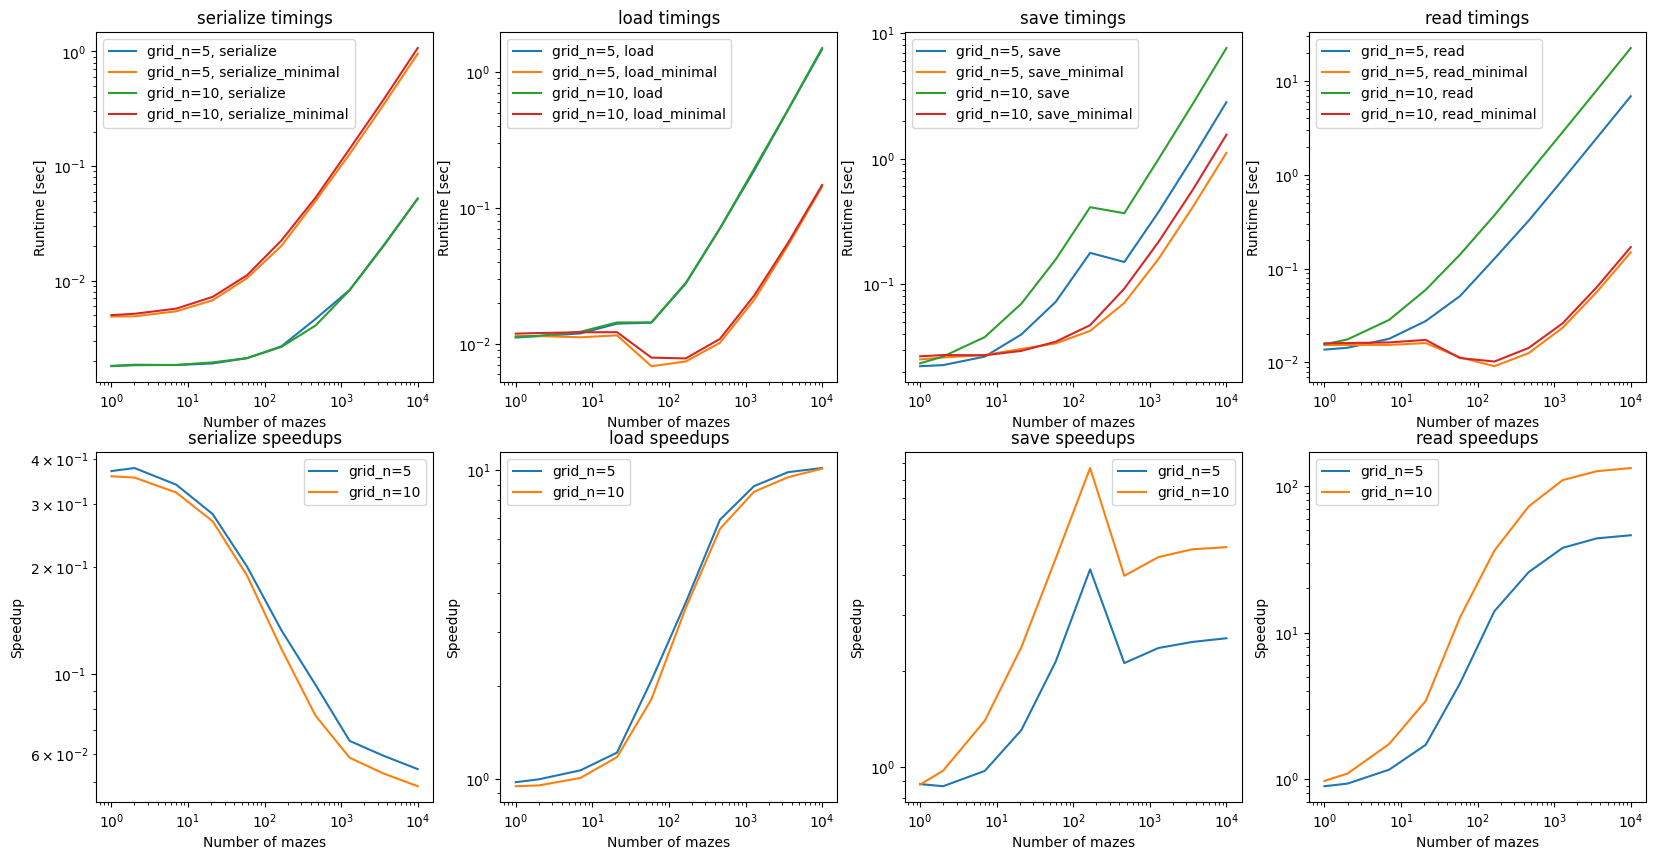

In [34]:
def plot_speeds(speeds: pd.DataFrame, column_measurement_prefixes: list[str] = ['serialize', 'load', 'save', 'read']) -> None:
	n_measurements: int = len(column_measurement_prefixes)
	fig, axs = plt.subplots(2, n_measurements, figsize=(n_measurements*5, 10))

	unique_grid_ns: list[int] = speeds['grid_n'].unique().tolist()

	for i, prefix in enumerate(column_measurement_prefixes):
		for grid_n in unique_grid_ns:
			# raw timings
			ax_timings = axs[0, i]

			ax_timings.plot(
				speeds.loc[speeds['grid_n'] == grid_n, 'n_mazes'], 
				speeds.loc[speeds['grid_n'] == grid_n, f'{prefix}'],
				label=f'grid_n={grid_n}, {prefix}'
			)
			ax_timings.plot(
				speeds.loc[speeds['grid_n'] == grid_n, 'n_mazes'], 
				speeds.loc[speeds['grid_n'] == grid_n, f'{prefix}_minimal'],
				label=f'grid_n={grid_n}, {prefix}_minimal'
			)

			ax_timings.legend()
			ax_timings.set_xscale('log')
			ax_timings.set_yscale('log')
			ax_timings.set_xlabel('Number of mazes')
			ax_timings.set_ylabel('Runtime [sec]')
			ax_timings.set_title(f'{prefix} timings')

			# speedups
			ax_speedups = axs[1, i]

			ax_speedups.plot(
				speeds.loc[speeds['grid_n'] == grid_n, 'n_mazes'], 
				speeds.loc[speeds['grid_n'] == grid_n, f'{prefix}_speedup'],
				label=f'grid_n={grid_n}'
			)

			ax_speedups.legend()
			ax_speedups.set_xscale('log')
			ax_speedups.set_yscale('log')
			ax_speedups.set_xlabel('Number of mazes')
			ax_speedups.set_ylabel('Speedup')
			ax_speedups.set_title(f'{prefix} speedups')


plot_speeds(SPEEDS)


Comparing rows 2 and 4, it appears that the `grid_n` has a relatively small effect on `serialize` and `load` runtimes. Those functions appear to run in $O(n_{\mathrm{mazes}})$ time. `grid_n` does impact `save` and `read`, but not their `_minimal` counterparts as much.

To compare the speed of analogous procedures vs `n_mazes`, the plots below show data from `speeds.loc[3:,:]`.